## Description of the project:

   In this assignment, we will curate a set of **CO2 measurements**, measured from cheap but inaccurate sensors, that have been deployed in the city of Zurich. The goal of the exercise is twofold: 

a) Learn how to deal with real world sensor timeseries data, and organize them efficiently using python dataframes.

b) Apply data science tools to model the measurements, and use the learned model to process them (e.g., detect outliers and drifts in the sensor measurements). 

The sensor network consists of 46 sites, located in different parts of the city. Each site contains three different sensors measuring (a) **CO2 concentration**, (b) **temperature**, and (c) **humidity**. Beside these measurements, we have the following additional information that can be used to process the measurements: 


1) The **altitude** at which the CO2 sensor is located, and the GPS coordinates (latitude, longitude).

2) A clustering of the city of Zurich in 17 different city zones and the **zone** in which the sensor belongs to. Some characteristic zones are industrial area, residential area, forest, glacier, lake, etc.



 Given this knowledge, you are asked to define an algorithm that curates the data, by detecting and removing potential drifts. The algorithm should be based on the fact that sensors in similar conditions are expected to have similar measurements. 




 
 






## Prior knowledge:
    
The average value of the CO2 in a city is approximately 400 ppm. However, the exact measurement in each site depends on parameters such as the temperature, the humidity, the altitude, and the level of traffic around the site. For example, sensors positioned in high altitude (mountains) and exposed to stronger winds, are expected to have a much lower and uniform level of CO2 than sensors that are positioned in a business area with much higher traffic activity. Moreover, we know that there is a strong dependence of the CO2 measurements on temperature and humidity.



### To start with: 

The following csv files will be needed: 

1) CO2_sensor_measurements.csv
    
   Description: It containts the CO2 measurements (CO2), the name of the site (LocationName), a unique sensor identifier (SensorUnit_ID), and the time instance in which the measurement was taken (timestamp).
    
2) temperature_humidity.csv

   Description: It contains the temperature and the humidity measurements for each sensor identifier, at each timestamp (Timestamp). For each SensorUnit_ID, the temperature and the humidity can be found in the corresponding columns of the dataframe (SensorUnit_ID.temperature, SensorUnit_ID.humidity).
    
3) sensor_metadata_updated.csv

   Description: It contains the name of the site (LocationName), the zone index (zone), the altitude in meters, and longitude, latitude. 
    


In [1]:
# Imports
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import folium
from folium import plugins
from folium.plugins import HeatMap

import sklearn
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge

from sklearn.linear_model import RidgeCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from causalimpact import CausalImpact
from statsmodels.tsa.arima_process import ArmaProcess


### PART I: Handling time series with pandas (10 points)

 a) **8/10** Merge the CO2_sensor_measurements.csv, temperature_humidity.csv files, and sensors_metadata.csv, into a single dataframe that contains as index the time instance (timestamp) of the measurements, and columns the location of the site (LocationName), the sensor ID (SensorUnit_ID), the CO2 measurement, the temperature, the humidity, the zone, the altitude, the longitude and the latitude. For each measurement, take the average over an interval of 30 min. If there are missing measurements, interpolate them linearly from measurements that are close by in time.

Hints: The following methods could be useful

    pandas.DataFrame.resample() https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html
    
    pandas.DataFrame.interpolate() https://pandas.pydata.org/pandasdocs/stable/generated/pandas.DataFrame.interpolate.html
    
    pandas.DataFrame.mean() https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.mean.html
    
    pandas.DataFrame.append() https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.append.html




In [2]:
df_co2_sensor_measurements = pd.read_csv('CO2_sensor_measurements.csv', sep='\t')

In [3]:
df_co2_sensor_measurements['timestamp'] = pd.to_datetime(df_co2_sensor_measurements['timestamp'])
df_co2_sensor_measurements = df_co2_sensor_measurements.rename(index=str, 
                                                               columns={'timestamp': 'Timestamp'})\
                                                       .set_index("Timestamp")
df_co2_sensor_measurements.head()

,LocationName,SensorUnit_ID,CO2
Timestamp,,,
2017-10-01 00:05:00,ZGHD,1014,593.321562
2017-10-01 00:15:00,ZGHD,1014,595.846258
2017-10-01 00:25:00,ZGHD,1014,595.845353
2017-10-01 00:45:00,ZGHD,1014,599.039129
2017-10-01 00:55:00,ZGHD,1014,594.996629


In [4]:
df_co2_sensor_measurements = df_co2_sensor_measurements.groupby(['SensorUnit_ID', 'LocationName']) \
                                                       .resample('30min') \
                                                       .mean() \
                                                       .interpolate()\
                                                       .drop(columns=['SensorUnit_ID'])
df_co2_sensor_measurements.head()

CO2
SensorUnit_ID LocationName Timestamp                      
1014          ZGHD         2017-10-01 00:00:00  595.004391
                           2017-10-01 00:30:00  597.017879
                           2017-10-01 01:00:00  596.487010
                           2017-10-01 01:30:00  598.787639
                           2017-10-01 02:00:00  595.366394

In [5]:
df_co2_sensor_measurements = df_co2_sensor_measurements.reset_index('LocationName').swaplevel(0,1)
df_co2_sensor_measurements.head()

,,LocationName,CO2
Timestamp,SensorUnit_ID,,
2017-10-01 00:00:00,1014,ZGHD,595.004391
2017-10-01 00:30:00,1014,ZGHD,597.017879
2017-10-01 01:00:00,1014,ZGHD,596.487010
2017-10-01 01:30:00,1014,ZGHD,598.787639
2017-10-01 02:00:00,1014,ZGHD,595.366394


In [6]:
df_temperature_humidity = pd.read_csv('temperature_humidity.csv', sep='\t')

In [7]:
df_temperature_humidity['Timestamp'] = pd.to_datetime(df_temperature_humidity['Timestamp'])
df_temperature_humidity = df_temperature_humidity.set_index("Timestamp")\
                                                 .resample('30min').mean().interpolate()
df_temperature_humidity.head()

,1014.temperature,1014.humidity,1015.temperature,1015.humidity,1016.temperature,1016.humidity,1017.temperature,1017.humidity,1018.temperature,1018.humidity,...,1291.temperature,1291.humidity,1292.temperature,1292.humidity,1297.temperature,1297.humidity,1298.temperature,1298.humidity,1299.temperature,1299.humidity
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-10-01 00:00:00,11.396667,92.440806,10.513333,92.204295,11.040000,92.959605,11.040000,89.914205,11.370000,91.059886,...,10.130000,97.310903,10.460000,95.701736,10.560000,94.513458,11.343333,90.577962,11.436667,89.886230
2017-10-01 00:30:00,11.325000,91.770691,10.576667,92.773956,10.996667,92.644257,10.960000,89.787048,11.273333,89.996857,...,10.130000,97.918076,10.456667,96.094014,10.463333,95.242065,11.290000,90.549988,11.326667,88.851176
2017-10-01 01:00:00,11.240000,91.096761,10.560000,92.866781,10.953333,92.062515,10.980000,89.294952,11.235000,90.005440,...,10.003333,96.909724,10.393333,97.449504,10.576667,95.600011,11.230000,89.885595,11.263333,88.593048
2017-10-01 01:30:00,11.260000,91.275734,10.510000,92.942439,10.896667,92.285675,10.993333,89.351537,11.223333,89.887502,...,9.916667,96.642695,10.310000,97.076935,10.516667,95.526896,11.245000,89.779419,11.300000,89.286051
2017-10-01 02:00:00,11.290000,91.061157,10.436667,92.884583,10.870000,92.477681,11.033333,89.207850,11.253333,89.595042,...,9.866667,96.340698,10.326667,97.756587,10.370000,95.427078,11.236667,90.560796,11.290000,89.628738


In [8]:
df_temperature_humidity.columns = df_temperature_humidity.columns.str.split('.', expand=True)
df_temperature_humidity = df_temperature_humidity.stack(level=0)\
                                                 .reset_index()\
                                                 .rename(columns={'level_1': 'SensorUnit_ID',
                                                                  'humidity': 'Humidity',
                                                                  'temperature': 'Temperature'})
df_temperature_humidity['SensorUnit_ID'] = pd.to_numeric(df_temperature_humidity['SensorUnit_ID'])
df_temperature_humidity.head()

,Timestamp,SensorUnit_ID,Humidity,Temperature
0,2017-10-01,1014,92.440806,11.396667
1,2017-10-01,1015,92.204295,10.513333
2,2017-10-01,1016,92.959605,11.040000
3,2017-10-01,1017,89.914205,11.040000
4,2017-10-01,1018,91.059886,11.370000


In [9]:
df_temperature_humidity = df_temperature_humidity.set_index(['Timestamp', 'SensorUnit_ID'])
df_temperature_humidity.head()

Humidity  Temperature
Timestamp  SensorUnit_ID                        
2017-10-01 1014           92.440806    11.396667
           1015           92.204295    10.513333
           1016           92.959605    11.040000
           1017           89.914205    11.040000
           1018           91.059886    11.370000

In [10]:
df_sensors_metadata_updated = pd.read_csv('sensors_metadata_updated.csv', 
                                          sep=',', 
                                          index_col=1)
df_sensors_metadata_updated.head()

,Unnamed: 0,zone,altitude,LAT,LON,X,Y
LocationName,,,,,,,
AJGR,0,2,627.8,47.33321,8.480300,243005.0,678731.4
BSCR,1,2,462.3,47.35581,8.430070,245468.0,674903.4
BUDF,2,10,490.2,47.36270,8.433110,246237.5,675123.8
KBRL,3,7,510.5,47.32582,8.537550,242242.3,683070.1
KTGM,4,2,530.3,47.32334,8.596422,242031.0,687523.9


In [11]:
df_sensors_metadata_updated = df_sensors_metadata_updated.drop([df_sensors_metadata_updated.columns[0]], 
                                                               axis=1)
df_sensors_metadata_updated = df_sensors_metadata_updated.rename(index=str,
                                                                 columns={'zone': 'Zone', 
                                                                          'altitude': 'Altitude',
                                                                          'LAT': 'Latitude',
                                                                          'LON': 'Longitude'})
df_sensors_metadata_updated.head()

,Zone,Altitude,Latitude,Longitude,X,Y
LocationName,,,,,,
AJGR,2,627.8,47.33321,8.480300,243005.0,678731.4
BSCR,2,462.3,47.35581,8.430070,245468.0,674903.4
BUDF,10,490.2,47.36270,8.433110,246237.5,675123.8
KBRL,7,510.5,47.32582,8.537550,242242.3,683070.1
KTGM,2,530.3,47.32334,8.596422,242031.0,687523.9


In [12]:
df_temperature_humidity.head()

Humidity  Temperature
Timestamp  SensorUnit_ID                        
2017-10-01 1014           92.440806    11.396667
           1015           92.204295    10.513333
           1016           92.959605    11.040000
           1017           89.914205    11.040000
           1018           91.059886    11.370000

In [13]:
df_co2_sensor_measurements.head()

,,LocationName,CO2
Timestamp,SensorUnit_ID,,
2017-10-01 00:00:00,1014,ZGHD,595.004391
2017-10-01 00:30:00,1014,ZGHD,597.017879
2017-10-01 01:00:00,1014,ZGHD,596.487010
2017-10-01 01:30:00,1014,ZGHD,598.787639
2017-10-01 02:00:00,1014,ZGHD,595.366394


In [14]:
df_timeseries = df_co2_sensor_measurements.merge(df_temperature_humidity,
                                                 how='outer',
                                                 left_on=['Timestamp', 'SensorUnit_ID'], 
                                                 right_on=['Timestamp', 'SensorUnit_ID'])
df_timeseries.head()

,,LocationName,CO2,Humidity,Temperature
Timestamp,SensorUnit_ID,,,,
2017-10-01 00:00:00,1014,ZGHD,595.004391,92.440806,11.396667
2017-10-01 00:30:00,1014,ZGHD,597.017879,91.770691,11.325000
2017-10-01 01:00:00,1014,ZGHD,596.487010,91.096761,11.240000
2017-10-01 01:30:00,1014,ZGHD,598.787639,91.275734,11.260000
2017-10-01 02:00:00,1014,ZGHD,595.366394,91.061157,11.290000


In [15]:
df_timeseries = df_timeseries.join(df_sensors_metadata_updated, how='left', on='LocationName')
df_timeseries = df_timeseries.dropna()
df_timeseries.head()

,,LocationName,CO2,Humidity,Temperature,Zone,Altitude,Latitude,Longitude,X,Y
Timestamp,SensorUnit_ID,,,,,,,,,,
2017-10-01 00:00:00,1014,ZGHD,595.004391,92.440806,11.396667,2.0,413.5,47.370446,8.523256,247188.9,681921.0
2017-10-01 00:30:00,1014,ZGHD,597.017879,91.770691,11.325000,2.0,413.5,47.370446,8.523256,247188.9,681921.0
2017-10-01 01:00:00,1014,ZGHD,596.487010,91.096761,11.240000,2.0,413.5,47.370446,8.523256,247188.9,681921.0
2017-10-01 01:30:00,1014,ZGHD,598.787639,91.275734,11.260000,2.0,413.5,47.370446,8.523256,247188.9,681921.0
2017-10-01 02:00:00,1014,ZGHD,595.366394,91.061157,11.290000,2.0,413.5,47.370446,8.523256,247188.9,681921.0


b) **2/10** Export the curated and ready to use timeseries to a csv file. 

In [16]:
df_timeseries.to_csv('timeseries.csv')

### PART II: Data visualization (20 points)

a) **6/20** Group the sites based on their altitude, by performing K-means clustering. Find the optimal number of clusters using the Elbow curve.  Add an additional column to the dataframe of the previous question indicating the altitude cluster index. 

In [17]:
def plot_k_means_elbow(K, distances):
    """ Plot the Elbow curve to help select the 
        number of clusters to use"""
    plt.figure(figsize=(10,6))
    plt.plot(K, distances, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Sum of squared distances of samples to their closest cluster center')
    plt.title('Elbow method for optimal number of clusters')
    plt.show()

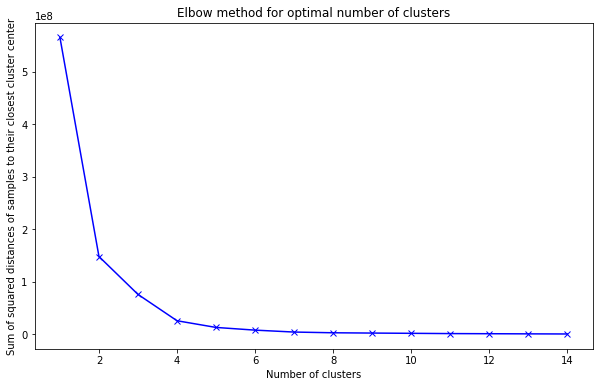

In [18]:
distances_altitude = []
altitudes = df_timeseries["Altitude"].values.reshape(-1,1)
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(altitudes)
    distances_altitude.append(km.inertia_)
plot_k_means_elbow(K, distances_altitude)

The elbow is at 4 clusters. Hence we take 4 clusters.

In [19]:
km = KMeans(n_clusters=4).fit(altitudes)
df_timeseries["Altitude cluster"] = km.labels_
df_timeseries.head()

,,LocationName,CO2,Humidity,Temperature,Zone,Altitude,Latitude,Longitude,X,Y,Altitude cluster
Timestamp,SensorUnit_ID,,,,,,,,,,,
2017-10-01 00:00:00,1014,ZGHD,595.004391,92.440806,11.396667,2.0,413.5,47.370446,8.523256,247188.9,681921.0,0
2017-10-01 00:30:00,1014,ZGHD,597.017879,91.770691,11.325000,2.0,413.5,47.370446,8.523256,247188.9,681921.0,0
2017-10-01 01:00:00,1014,ZGHD,596.487010,91.096761,11.240000,2.0,413.5,47.370446,8.523256,247188.9,681921.0,0
2017-10-01 01:30:00,1014,ZGHD,598.787639,91.275734,11.260000,2.0,413.5,47.370446,8.523256,247188.9,681921.0,0
2017-10-01 02:00:00,1014,ZGHD,595.366394,91.061157,11.290000,2.0,413.5,47.370446,8.523256,247188.9,681921.0,0



b) **2/20** Plot the monthly median CO2 measurement for each site with respect to the altitude. Annotate each point of the plot with the name of the location (LocatioName), and give the same color to stations that belong to the same altitude  cluster.


    

In [20]:
df_locations = df_timeseries.groupby("LocationName").median()
df_locations.head()

,CO2,Humidity,Temperature,Zone,Altitude,Latitude,Longitude,X,Y,Altitude cluster
LocationName,,,,,,,,,,
AJGR,334.785793,79.567156,10.637500,2.0,627.8,47.33321,8.480300,243005.0,678731.4,1
BSCR,474.502250,91.072601,9.154167,2.0,462.3,47.35581,8.430070,245468.0,674903.4,3
BUDF,422.793126,85.135661,9.895000,10.0,490.2,47.36270,8.433110,246237.5,675123.8,3
KBRL,410.100150,76.864126,11.440000,7.0,510.5,47.32582,8.537550,242242.3,683070.1,3
KTGM,444.395518,77.902677,10.906667,2.0,530.3,47.32334,8.596422,242031.0,687523.9,3


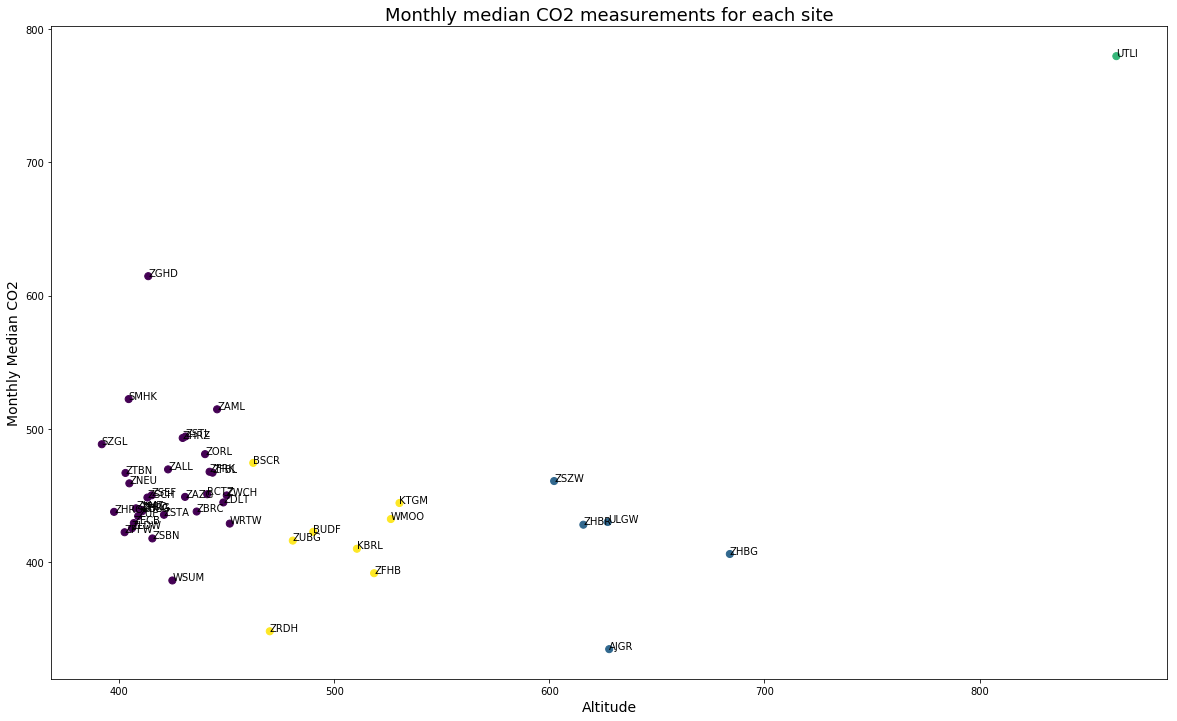

In [21]:
plt.figure(figsize=(20,12))
plt.scatter(df_locations["Altitude"], df_locations["CO2"], c=df_locations["Altitude cluster"], s=50)
for i, txt in enumerate(df_locations.index):
    plt.annotate(txt, (df_locations["Altitude"][i], df_locations["CO2"][i]))
plt.title("Monthly median CO2 measurements for each site", fontsize=18)
plt.xlabel("Altitude", fontsize=14)
plt.ylabel("Monthly Median CO2", fontsize=14)
plt.show()

c) **6/20** Plot the stations on an interactive Zurich map, and dispay their location name. You can use the python library Folium for that (https://pypi.org/project/folium/), but any other any visualization tool can be used.

For the name of each station, it is needed to click under the circle

In [22]:
map_zh = folium.Map(location=[47.37, 8.52], 
                    zoom_start=11.5, 
                    tiles='cartodbpositron')
df_sensors_metadata_updated.reset_index()\
                           .apply(lambda row: folium.CircleMarker(location=[row["Latitude"], 
                                                                            row["Longitude"]], 
                                                                  radius=6, 
                                                                  popup=row["LocationName"], 
                                                                  fill_color="red").add_to(map_zh), axis=1)
map_zh

d) **6/20** Plot a time-varying heatmap of the mean daily CO2 concentration for all the stations.  

In [23]:
df_heatmap = df_timeseries.groupby([pd.Grouper(freq="1D", level=0), "LocationName"]).mean()
df_heatmap = df_heatmap.reset_index(level=1)[["Latitude", "Longitude", "CO2"]]
df_heatmap.dropna()
df_heatmap.head()

,Latitude,Longitude,CO2
Timestamp,,,
2017-10-01,47.33321,8.480300,336.656408
2017-10-01,47.35581,8.430070,450.830935
2017-10-01,47.36270,8.433110,418.328012
2017-10-01,47.32582,8.537550,405.815779
2017-10-01,47.32334,8.596422,435.024911


In [24]:
data = df_heatmap.groupby("Timestamp")[["Latitude", "Longitude", "CO2"]]\
                 .apply(lambda x: x.values.tolist())\
                 .tolist()
dates = [d.strftime('%Y-%m-%d') for d in df_heatmap.index.unique()]

In [25]:
hm = plugins.HeatMapWithTime(data, index=dates)
hm.add_to(map_zh)
map_zh

### PART III: Model fitting for data curation (30 points)

a) **2/30** The technician in charge of these sensors reported that one of the CO2 sensors ('ZSBN') is exhibiting a drift on Oct. 24. Verify the drift by visualizing the CO2 concentration of the drifting sensor and some other random sensors from the network. 



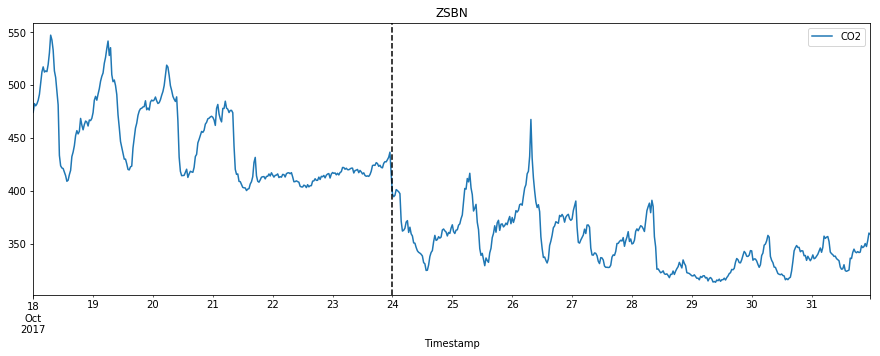

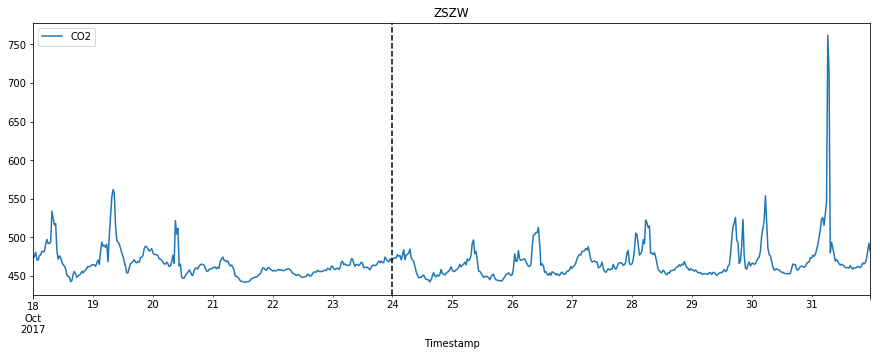

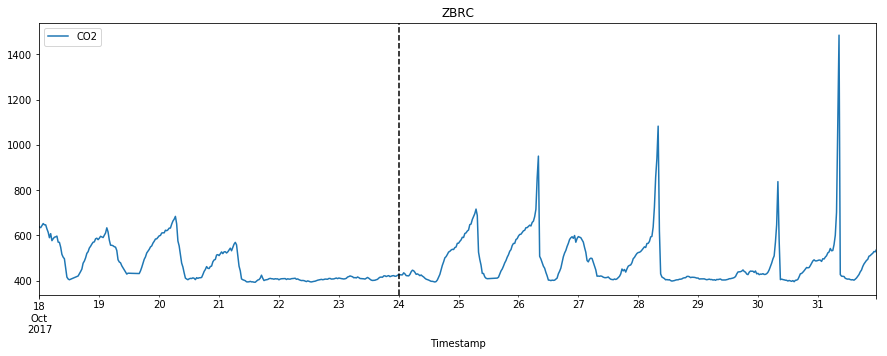

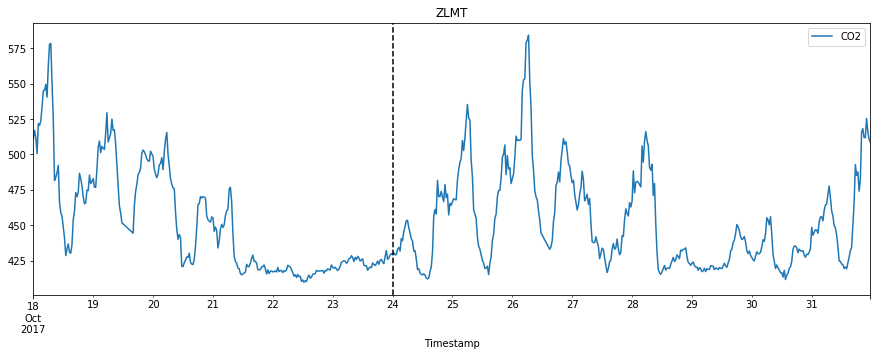

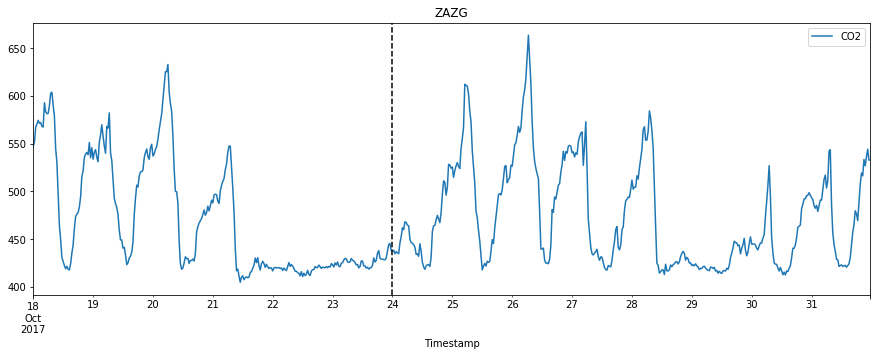

In [26]:
# Keep a smaller range of the period containing the drift
df_ts_short_per = df_timeseries.reset_index(level=1)['2017-10-18':'2018-10-28']

# Plot the graph of the drifting sensor against the one of random sensors
df_ts_short_per[df_ts_short_per.LocationName == "ZSBN"].plot(y="CO2", figsize=(15,5), title="ZSBN")
plt.axvline("2017-10-24", linestyle='--', color='k')
valid_loc_names = list(df_ts_short_per.LocationName.unique())
valid_loc_names.remove("ZSBN")
for location in random.sample(valid_loc_names, 4):
    df_ts_short_per[df_ts_short_per.LocationName == location].plot(y="CO2", figsize=(15,5), title=location)
    plt.axvline("2017-10-24", linestyle='--', color='k')
    plt.show()

As we can see from the plots, the CO2 levels of the ZSBN station were the only ones that after the 24th went down. The other stations report no decrease so we can conclude there is something wrong with this station's measurements.


b) **6/30** We want to reconstruct the CO2 concentration of the drifting sensor had the drift not happened. Train a forecasting model on the CO2 values of the drifting sensor. Use linear regression with features the past CO2 values over an interval of 3 hours. Plot and compare the actual CO2 measurements, and the values obtained by the prediction of the linear model for the entire month of October, together with their confidence interval obtained from cross validation.  What do you observe? 






In [27]:
def plot_pred_conc(pred_df, title):
    """ Plot the predicted values of CO2 concentration against
        the values of CO2 concentration of the drifting sensor. """
    drift_sens = df_timeseries.reset_index(level=1)['2017-10-18':'2018-10-28']
    pred_df = pred_df['2017-10-18':'2018-10-28']
    figure = plt.figure(figsize=(16, 6))
    plt.plot(drift_sens[drift_sens.LocationName == "ZSBN"].index, 
             drift_sens[drift_sens.LocationName == "ZSBN"]["CO2"], 
             color="coral", 
             label="Drifting sensor values")
    plt.plot(pred_df.index, pred_df["CO2"], color="limegreen", label="Predicted values")
    plt.fill_between(pred_df.index, 
                     (pred_df["CO2"] - 2*pred_df["std"]), 
                     (pred_df["CO2"] + 2*pred_df["std"]), 
                     color='b', 
                     alpha=.4, 
                     label="95% interval")
    plt.axvline("2017-10-24", linestyle='--', color='k')
    plt.title(title)
    plt.legend()
    plt.show()

In [28]:
def plot_pred(y_test, y_pred, title):
    """ Plot the predicted values y_pred against
        the test values y_test. """
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=4)
    plt.title(title)
    ax.set_xlabel('Original')
    ax.set_ylabel('Predicted')
    plt.show()

In [31]:
def cross_val_ts(X, y, n_splits=10, test_size=0.2):
    """ Cross-validate the time series using the valid features
        and predictions. Display the accuracy interval. """
    scores = []
    n_models = []
    for split in range(n_splits):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        model = LinearRegression()
        model = model.fit(X_train, y_train)
        scores.append(model.score(X_test, y_test))
        n_models.append(model)
    score = np.asarray(scores)
    print(score)
    print("Accuracy interval is: {:.2f} (± {:.2f})".format(score.mean(), 1.96*score.std()))
    return n_models

In [32]:
def predict_co2(X, y, test_size, predictor):
    """ Return the predicted values of the CO2 concentration,
        as well as the test values. """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    predictor.fit(X_train, y_train)
    y_pred = predictor.predict(X_test)
    return y_test, y_pred

In [33]:
def rolling_window_list(df, feature, window):
    """ Return dataframe that has as columns a feature's
        measurement from a given time down to a given time. """
    data_windows = []
    for i in range(len(df)):
        data_windows.append(list(df[feature][i : i + window]))
    data = pd.DataFrame(data_windows)
    data.columns = [feature] + [feature + " at t-" + str(i) for i in range(1, window)]
    data.index = df.index
    return data

In [34]:
# Prepare the dataframe for the linear regression
df_training = rolling_window_list(df_timeseries[df_timeseries.LocationName == "ZSBN"], "CO2", 6)\
                .dropna()\
                .reset_index(level=1).drop("SensorUnit_ID", axis=1)

In [35]:
# Separate the features and the targets
X_full = df_training[df_training.columns[1:]]
y_full = df_training["CO2"]

# We train the model only with values up to the 23rd of october"
X = X_full[:"2017-10-23"]
y = y_full[:"2017-10-23"]

In [36]:
n_models = cross_val_ts(X,y)

[0.84793181 0.84461502 0.91708782 0.89645542 0.9680768  0.84340804
 0.92692452 0.92008829 0.84892495 0.84154541]
Accuracy interval is: 0.89 (± 0.09)


In [37]:
# Now that we have tested the model on valid data, we predict
# all the CO2 values to better visualize the accuracy of the model
X_pred = X_full
y_preds = []
for model in n_models:
    y_p = model.predict(X_pred)
    y_preds.append(y_p)
y_predicted = np.mean(y_preds, axis=0)
y_std = np.std(y_preds, axis=0)

In [38]:
# Make a copy of the initial dataframe and replace the uncorrect values by the predictions
df_ts_pred_b = df_training.copy()
df_ts_pred_b["CO2"] = y_predicted
df_ts_pred_b["std"] = y_std

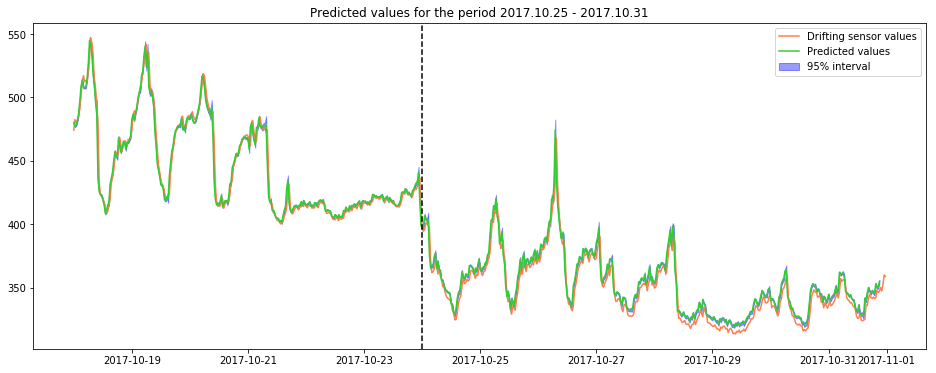

In [39]:
plot_pred_conc(df_ts_pred_b, "Predicted values for the period 2017.10.25 - 2017.10.31")

From the validation score and the plots we can see that our model given past information is capable of making an accurate estimation of the CO2 value. But due to only using the CO2 values, the predictions after the shift are very close to the actual values measured by the station, this can be explained easily as we are already feeding corrupt data to the model to make a prediction for times after the shift. We know we need other data to give a better prediction.

c) **2/30** Train a second forecasting model on the CO2 values of the drifting sensor. In this step, include current values of temperature and humidity as features,  as well as their past values over the same interval of three hours. Plot and compare the actual CO2 measurements, the values obtained by the prediction of the linear model for the entire month of October, together with their confidence interval obtained from cross validation. Are you able to remove the drift? If yes, how, if no, why? 





In [40]:
# Prepare the dataframe for the linear regression
df_temp = rolling_window_list(df_timeseries[df_timeseries.LocationName == "ZSBN"], "Temperature", 6)\
            .dropna()\
            .reset_index(level=1)\
            .drop("SensorUnit_ID", axis=1)
df_humid = rolling_window_list(df_timeseries[df_timeseries.LocationName == "ZSBN"], "Humidity", 6)\
            .dropna()\
            .reset_index(level=1)\
            .drop("SensorUnit_ID", axis=1)

df_training2 = df_training.join(df_temp).join(df_humid)

# Prepare the list of features
features = df_training2.columns[1:]

In [41]:
# Separate the features and the targets
X_full = df_training2[features]
y_full = df_training2["CO2"]

# We train the model only with values up to 23rd of october"
X = X_full[:"2017-10-23"]
y = y_full[:"2017-10-23"]

In [42]:
n_models = cross_val_ts(X, y)

[0.94873789 0.96863044 0.95316614 0.94770688 0.88257193 0.96038669
 0.96244777 0.95865095 0.8748418  0.97096099]
Accuracy interval is: 0.94 (± 0.06)


In [43]:
# Now that we have tested the model on valid data, we predict
# all the CO2 values to better visualize the accuracy of the model
X_pred = X_full
y_preds = []
for model in n_models:
    y_p = model.predict(X_pred)
    y_preds.append(y_p)
y_predicted = np.mean(y_preds, axis=0)
y_std = np.std(y_preds, axis=0)

In [44]:
# Make a copy of the initial dataframe and replace the uncorrect values by the predictions
df_ts_pred_c = df_training.copy()
df_ts_pred_c["CO2"] = y_predicted
df_ts_pred_c["std"] = y_std

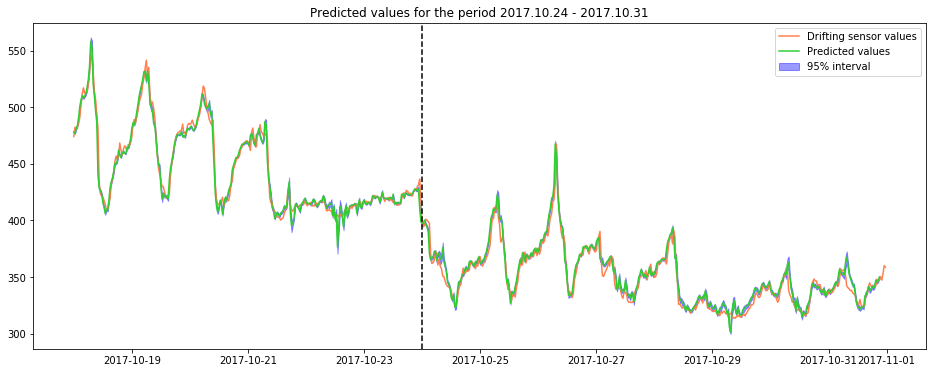

In [45]:
plot_pred_conc(df_ts_pred_c, "Predicted values for the period 2017.10.24 - 2017.10.31")

Temperature and humidity do not vary that much to help us improve our model prediction after the shift. We get an even more accurate approximation of the given data as we add some extra information but this is not what we want.

d) **3/30** Train another forecasting model on the CO2 values of the drifting sensors. This time, use linear regression with features only temperature, and humidity (remove past values of CO2). Plot and compare the actual CO2 measurements, and the values obtained by the prediction of the linear model for the entire month of October,  together with their confidence interval obtained from cross validation. Try several training/validation ratios: 5%, 10%, 20%, 30%. Are you able to remove the drift? What do you observe?

In [46]:
# Prepare the list of features
features = df_training2.columns[6:]
print(features)

Index(['Temperature', 'Temperature at t-1', 'Temperature at t-2',
       'Temperature at t-3', 'Temperature at t-4', 'Temperature at t-5',
       'Humidity', 'Humidity at t-1', 'Humidity at t-2', 'Humidity at t-3',
       'Humidity at t-4', 'Humidity at t-5'],
      dtype='object')


In [47]:
# Separate the features and the targets
X_full = df_training2[features]
y_full = df_training2["CO2"]

# Train the model only with values up to 21st of october"
X = X_full[:"2017-10-23"]
y = y_full[:"2017-10-23"]

[0.53046181 0.57958891 0.51681353 0.29879361 0.4676381  0.63176287
 0.50008271 0.44289865 0.45844316 0.44361142]
Accuracy interval is: 0.49 (± 0.17)


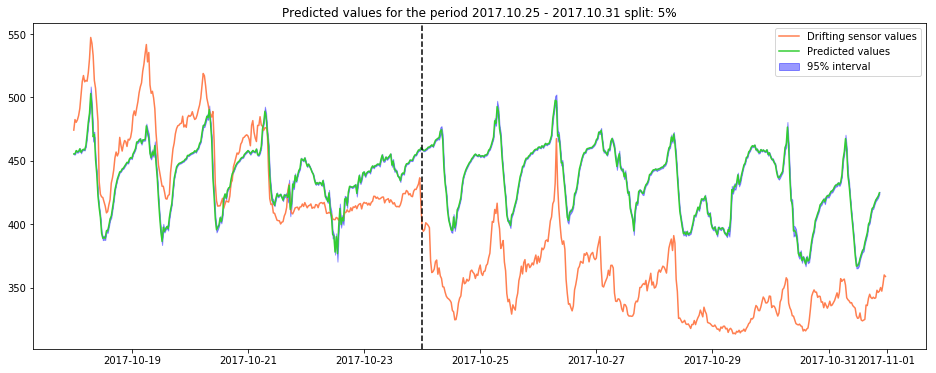

[0.54110318 0.58294459 0.50759386 0.45856864 0.41825304 0.4548061
 0.42013909 0.42178023 0.51676002 0.49769073]
Accuracy interval is: 0.48 (± 0.10)


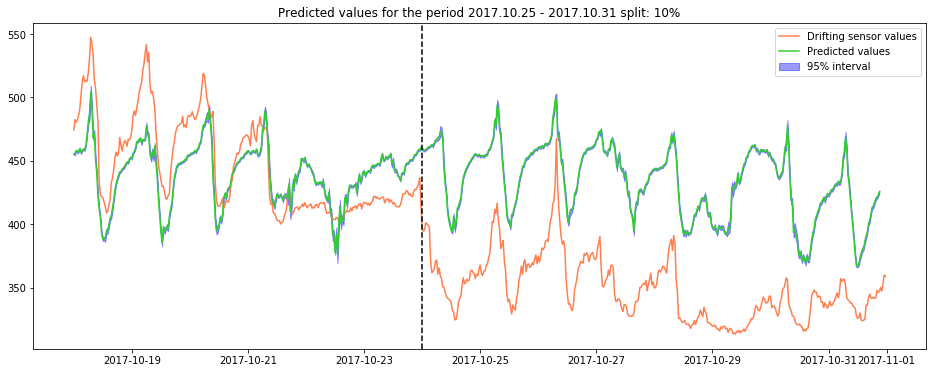

[0.48429326 0.47437893 0.50836317 0.49340957 0.47141674 0.47279139
 0.53232915 0.38489563 0.43716317 0.43752213]
Accuracy interval is: 0.47 (± 0.08)


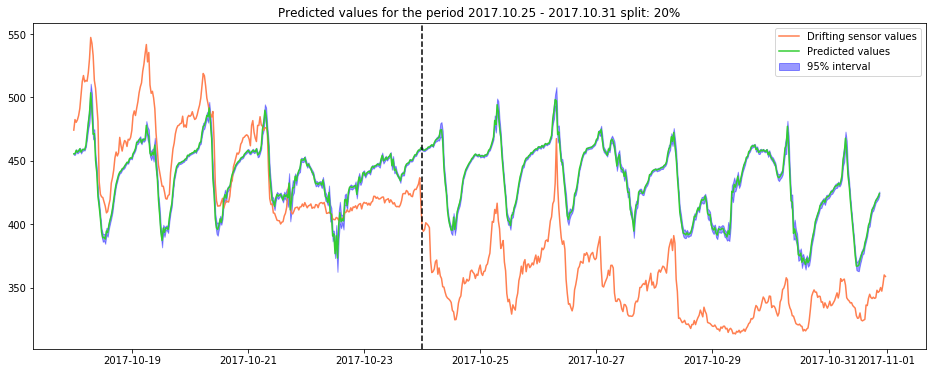

[0.45440542 0.43711891 0.47286847 0.47518579 0.45098191 0.45145765
 0.45020622 0.45254458 0.47436471 0.50514967]
Accuracy interval is: 0.46 (± 0.04)


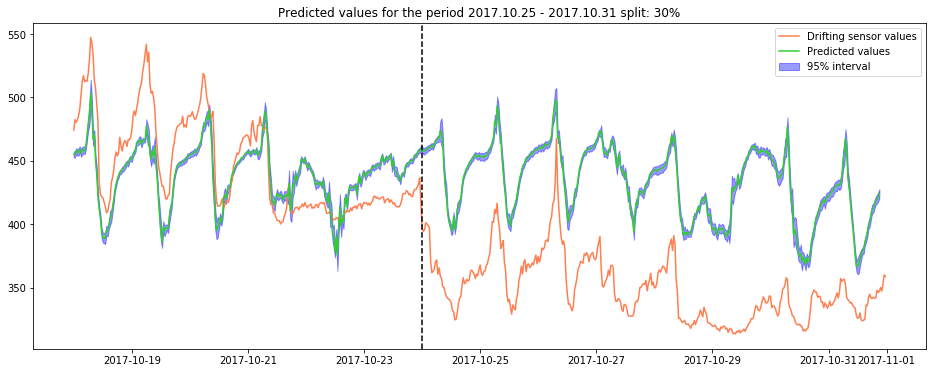

In [48]:
for size in [0.05,0.1,0.2,0.3]:
    n_models = cross_val_ts(X,y, test_size=size)

    # Now that we have tested the model on valid data, we predict
    # all the CO2 values to better visualize the accuracy of the model
    X_pred = X_full
    y_preds = []
    for model in n_models:
        y_p = model.predict(X_pred)
        y_preds.append(y_p)
    y_predicted = np.mean(y_preds, axis=0)
    y_std = np.std(y_preds, axis=0)

    # Make a copy of the initial dataframe and replace the uncorrect values by the predictions
    df_ts_pred_d = df_training.copy()
    df_ts_pred_d["CO2"] = y_predicted
    df_ts_pred_d["std"] = y_std
    plot_pred_conc(df_ts_pred_d, 
                   "Predicted values for the period 2017.10.25 - 2017.10.31 split: {:.0f}%".format(size*100))

Unfortunately, we see here that the predictions are not accurate. As we train our model using temperature and humidity, these values do not vary much and our model does not make a good approximation. On the positive side, however, the predictions after the shift are more appropiate, as there is no visible shift in the predicted model.

e) **7/30** Build a better linear regression model by exploting the fact that the CO2 concentrations, as measured by the sensors experiencing similar conditions, are expected to be similar. Apply the learned model to the drifting sensor, and plot the results. Try several training/validation ratios: 5%, 10%, 20%, 30%. What do you conclude? 

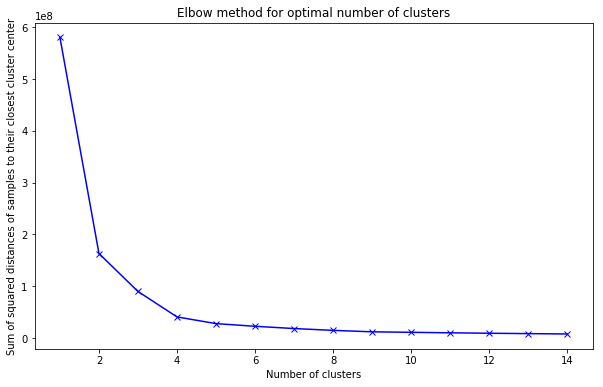

In [49]:
# Elbow curve method to find the optimal number of cluster for humidity, temperature and altitude 
distances = []
attributes = df_timeseries[["Humidity", "Temperature", "Altitude"]].values.reshape(-1,3)
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km = km.fit(attributes)
    distances.append(km.inertia_)
plot_k_means_elbow(K, distances)

The elbow is at 3 clusters. Hence we take 3 clusters.

In [50]:
# Apply KMeans with the number of cluster found previously
km = KMeans(n_clusters=3, random_state=42).fit(attributes)
df_timeseries["Cluster"] = km.labels_

In [51]:
# Keep the observations of the sensors similar to the drifting one
data_cluster = df_timeseries[df_timeseries.LocationName  == "ZSBN"].Cluster.unique()[0]
df_training3 = df_timeseries[df_timeseries["Cluster"] == data_cluster]

In [53]:
def same_size(array, length):
    """ If the len(array) > length return the 
        length first elements of array. """
    if(len(array) == length):
        return array
    else:
        last = len(array) - length
        return array[:-last]

In [54]:
# Keep only the observations before the drift to train the model
valid_data = df_training3.reset_index(level=1)[:"2017-10-23"]

# Prepare the targets for the regression
valid_data_y = valid_data[valid_data["LocationName"] == "ZSBN"]["CO2"]

# Prepare the features for the regression
valid_data_x = valid_data[valid_data["LocationName"] != "ZSBN"].groupby(level=0).agg({"CO2": list})
valid_data_x["CO2"] = valid_data_x["CO2"].apply(lambda row: np.asarray(row))
valid_data_x["Size"] = valid_data_x["CO2"].apply(lambda row: len(row))
length_lists = np.unique(valid_data_x["Size"]).min()
valid_data_x["CO2"] = valid_data_x["CO2"].apply(lambda row: same_size(row, length_lists))
valid_data_x["Size"] = valid_data_x["CO2"].apply(lambda row: len(row))

In [55]:
X = np.stack(valid_data_x["CO2"].values)
y = valid_data_y

[0.94497514 0.95944947 0.81703497 0.93595262 0.8933142  0.93559187
 0.90896828 0.95731808 0.95485616 0.96719835]
Accuracy interval is: 0.93 (± 0.08)


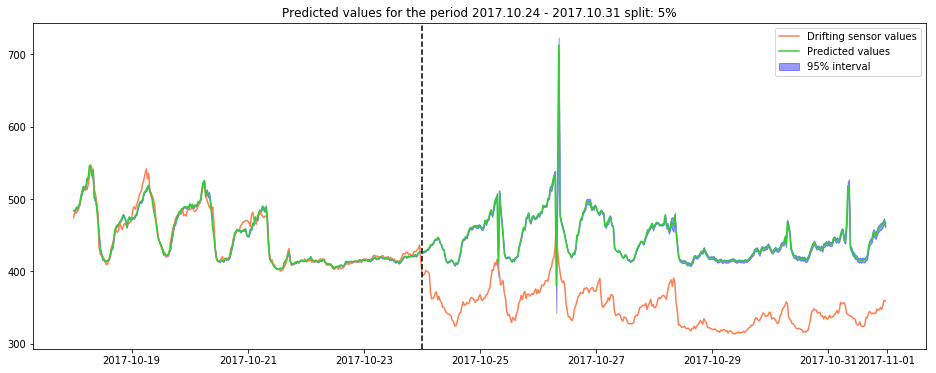

[0.91949233 0.91286165 0.95625135 0.94077121 0.94328477 0.92533326
 0.95371082 0.83250422 0.94185395 0.96170276]
Accuracy interval is: 0.93 (± 0.07)


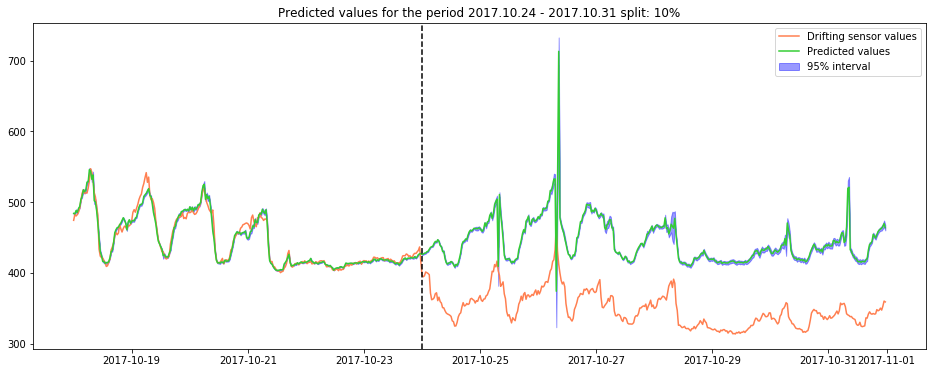

[0.86840683 0.9384325  0.93706789 0.88097453 0.90109008 0.93675736
 0.78386008 0.94652694 0.79126016 0.93296122]
Accuracy interval is: 0.89 (± 0.11)


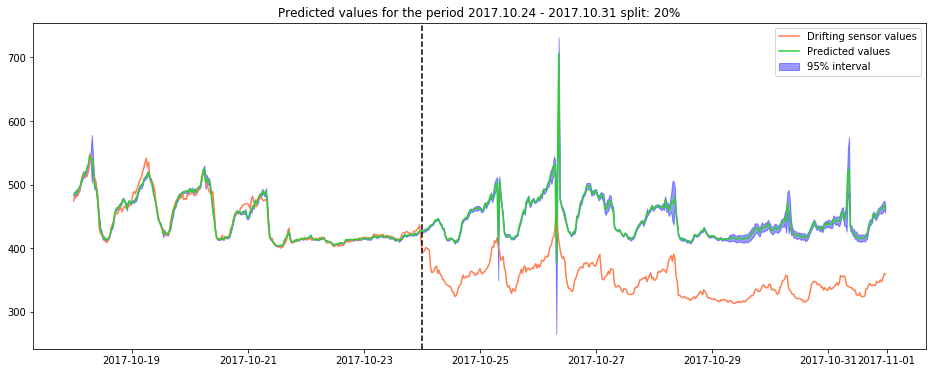

[0.81171274 0.90007049 0.94517782 0.94003663 0.92467361 0.90241407
 0.90310037 0.90919717 0.93191028 0.95617733]
Accuracy interval is: 0.91 (± 0.08)


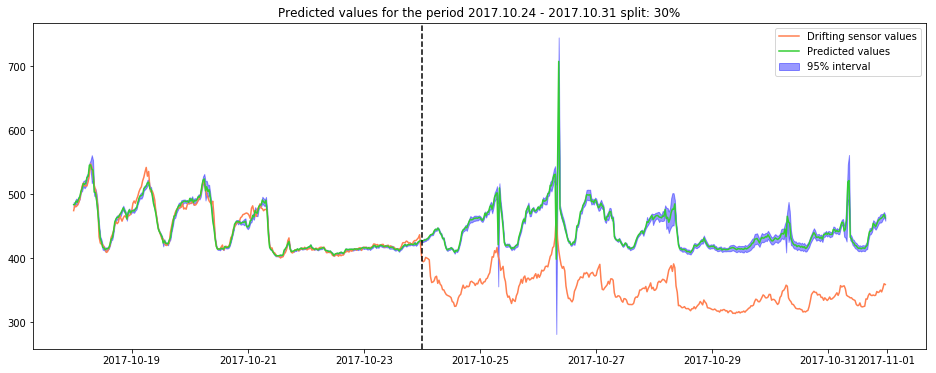

In [56]:
for size in [0.05,0.1,0.2,0.3]:
    n_models = cross_val_ts(X,y, test_size=size)

    # Now that we have tested the model on valid data, we predict
    # all the CO2 values to better visualize the accuracy of the model
    X_pred = df_training3.reset_index(level=1)

    X_pred = X_pred[X_pred["LocationName"] != "ZSBN"].groupby(level=0).agg({"CO2": list})
    X_pred["CO2"] = X_pred["CO2"].apply(lambda row: np.asarray(row))
    X_pred["Size"] = X_pred["CO2"].apply(lambda row: len(row))
    length_lists = np.unique(X_pred["Size"]).min()
    X_pred["CO2"] = X_pred["CO2"].apply(lambda row: same_size(row, length_lists))
    X_pred["Size"] = X_pred["CO2"].apply(lambda row: len(row))
    X_pred = np.stack(X_pred["CO2"].values)
    y_preds = []
    for model in n_models:
        y_p = model.predict(X_pred)
        y_preds.append(y_p)
    y_predicted = np.mean(y_preds, axis=0)
    y_std = np.std(y_preds, axis=0)

    # Make a copy of the initial dataframe and replace the uncorrect values by the predictions
    df_ts_pred_e = df_training3.copy()
    df_ts_pred_e_fin = df_ts_pred_e[df_ts_pred_e.LocationName == "ZSBN"].reset_index(level=1)
    df_ts_pred_e_fin["CO2"] = y_predicted
    df_ts_pred_e_fin["std"] = y_std
    plot_pred_conc(df_ts_pred_e_fin, 
                   "Predicted values for the period 2017.10.24 - 2017.10.31 split: {:.0f}%".format(size*100))

From the results and graph, we see that this is a pretty good approach. The model predictions are very accurate prior to the drift, while the graph afterwards shows reasonable values. This is what we wanted and we consider this model to be a fairly decent estimator of the CO2 measurements.

f) **10/30** In this question, we will use Bayesian Structural Time Series modeling to reconstruct counterfactual values, that is, what the CO2 measurements of the faulty sensor should have been, had the malfunction not happened on October 21.  We will use the information of provided by similar sensors (the ones you identified in the previous question), together with the covariates associated with the faulty sensors that were not affected by the malfunction (such as temperature and humidity).

To answer this question, you can choose between a Python port of the CausalImpact package (such as https://github.com/dafiti/causalimpact) or the original R version (https://google.github.io/CausalImpact/CausalImpact.html) that you can run in your notebook via an R kernel (https://github.com/IRkernel/IRkernel).

Is the counterfactual reconstruction of CO2 measurements significantly different from the observed measurements? 


In [58]:
dated_data = df_timeseries[(df_timeseries["Cluster"] == data_cluster) &
                           (df_timeseries["LocationName"] != "ZSBN")].groupby(level=0)\
                                                                     .agg({"CO2": list,
                                                                           "Temperature": list,
                                                                           "Humidity": list})

length_l = len(dated_data.values[-1][0])

pd_CO2 = pd.DataFrame(dated_data["CO2"].values.tolist(),
                      index=dated_data.index, 
                      columns=["CO2-" + str(i) for i in range(length_l)])
pd_hum = pd.DataFrame(dated_data["Humidity"].values.tolist(),
                      index=dated_data.index, 
                      columns=["Hum-" + str(i) for i in range(length_l)])
pd_temp = pd.DataFrame(dated_data["Temperature"].values.tolist(),
                       index=dated_data.index, 
                       columns=["Temp-" + str(i) for i in range(length_l)])

data_1 = df_timeseries[df_timeseries["LocationName"] == "ZSBN"]["CO2"].reset_index(level=1)["CO2"]
data_2 = pd.concat([pd.concat([pd_CO2, pd_hum], axis=1), pd_temp], axis=1).dropna(axis=1)

data = pd.concat([data_1, data_2], axis=1)
columns= ["y"] + ["x"+str(i) for i in range(99)]
data.columns = columns

data.head()

,y,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-10-01 00:00:00,418.493079,595.004391,472.855962,440.373573,425.095878,425.687625,426.441072,412.351297,337.298130,445.905382,...,10.493333,10.516667,10.875000,11.120000,11.143333,10.933333,10.460000,10.560000,11.343333,11.436667
2017-10-01 00:30:00,418.169200,597.017879,471.896079,441.060635,424.306724,428.453325,425.014187,415.305246,340.127627,448.274248,...,10.520000,10.470000,10.703333,10.946667,11.003333,10.963333,10.456667,10.463333,11.290000,11.326667
2017-10-01 01:00:00,421.749522,596.487010,471.753322,446.242833,426.618723,427.350753,423.912754,413.907776,338.640770,451.841394,...,10.370000,10.496667,10.636667,10.843333,11.033333,10.826667,10.393333,10.576667,11.230000,11.263333
2017-10-01 01:30:00,424.363039,598.787639,472.534124,442.993198,430.540983,429.705363,424.853283,412.466478,342.613645,449.712983,...,10.253333,10.453333,10.570000,10.780000,10.986667,10.653333,10.310000,10.516667,11.245000,11.300000
2017-10-01 02:00:00,423.172512,595.366394,472.269867,443.285766,428.007043,428.621242,422.021929,415.665103,342.824630,455.367638,...,10.206667,10.433333,10.486667,10.726667,10.956667,10.616667,10.326667,10.370000,11.236667,11.290000


In [59]:
pre_period = ["2017-10-01 00:00:00", "2017-10-23 23:30:00"]
post_period = ["2017-10-24 00:00:00", "2017-10-31 23:30:00"]

ci = CausalImpact(data, pre_period, post_period)

/Users/franckdessimoz/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  % freq, ValueWarning)
/Users/franckdessimoz/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/Users/franckdessimoz/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/franckdessimoz/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
/Users/franckdessimoz/anaconda/lib/python3.6/site-packages/statsmo

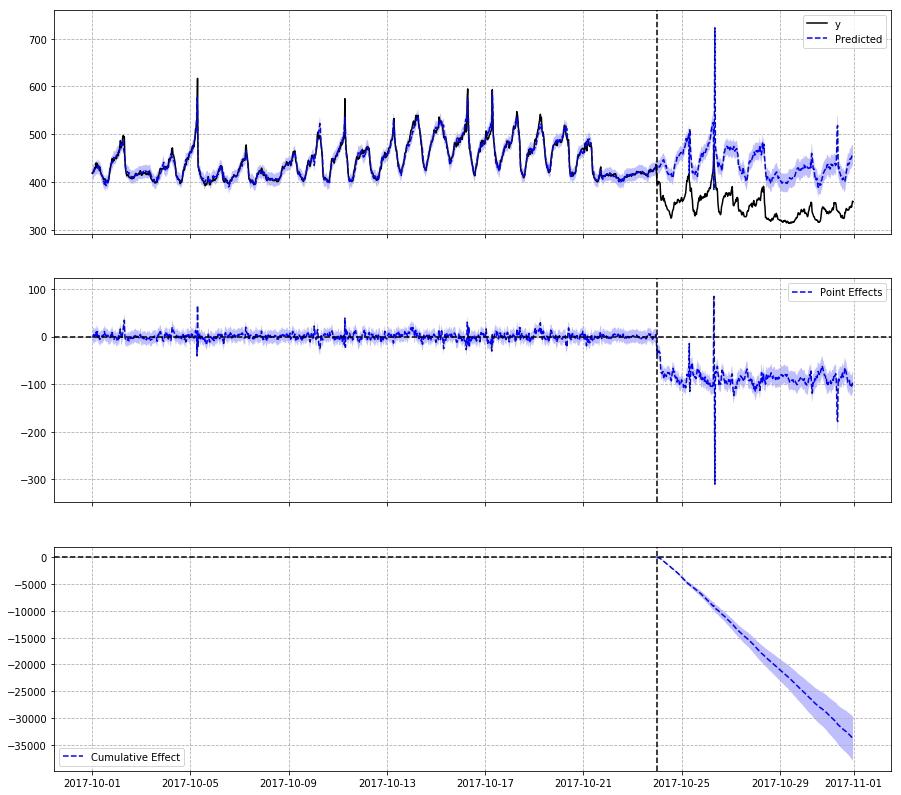

In [60]:
ci.plot(figsize=(15,14))

In [61]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    349.5              134197.7
Prediction (s.d.)         437.5 (5.5)        168010.9 (2101.8)
95% CI                    [426.8, 448.3]     [163893.4, 172132.5]

Absolute effect (s.d.)    -88.1 (5.5)        -33813.2 (2101.8)
95% CI                    [-98.8, -77.3]     [-37934.8, -29695.7]

Relative effect (s.d.)    -20.1% (1.2%)      -20.1% (1.2%)
95% CI                    [-22.6%, -17.7%]   [-22.6%, -17.7%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.00%

For more details run the command: print(impact.summary('report'))


In [62]:
ci.inferences.head()

,post_cum_y,preds,post_preds,post_preds_lower,post_preds_upper,preds_lower,preds_upper,post_cum_pred,post_cum_pred_lower,post_cum_pred_upper,point_effects,point_effects_lower,point_effects_upper,post_cum_effects,post_cum_effects_lower,post_cum_effects_upper
Timestamp,,,,,,,,,,,,,,,,
2017-10-01 00:00:00,NaN,427.252941,NaN,NaN,NaN,-72079.493214,72933.999096,NaN,NaN,NaN,-8.759861,-72515.506016,72497.986294,NaN,NaN,NaN
2017-10-01 00:30:00,NaN,420.482826,NaN,NaN,NaN,401.748986,439.216666,NaN,NaN,NaN,-2.313626,-21.047466,16.420215,NaN,NaN,NaN
2017-10-01 01:00:00,NaN,420.248235,NaN,NaN,NaN,404.012605,436.483865,NaN,NaN,NaN,1.501287,-14.734344,17.736917,NaN,NaN,NaN
2017-10-01 01:30:00,NaN,420.577339,NaN,NaN,NaN,405.259297,435.895381,NaN,NaN,NaN,3.785700,-11.532343,19.103742,NaN,NaN,NaN
2017-10-01 02:00:00,NaN,424.555661,NaN,NaN,NaN,409.713491,439.397831,NaN,NaN,NaN,-1.383149,-16.225319,13.459021,NaN,NaN,NaN


In [63]:
y_predicted_ci = ci.inferences["preds"]

In [64]:
df_ts_pred_f = df_training3.copy()
df_ts_pred_f_fin = df_ts_pred_f[df_ts_pred_f.LocationName == "ZSBN"].reset_index(level=1)
df_ts_pred_f_fin["CO2"] = y_predicted_ci
df_ts_pred_f_fin["std"] = 0

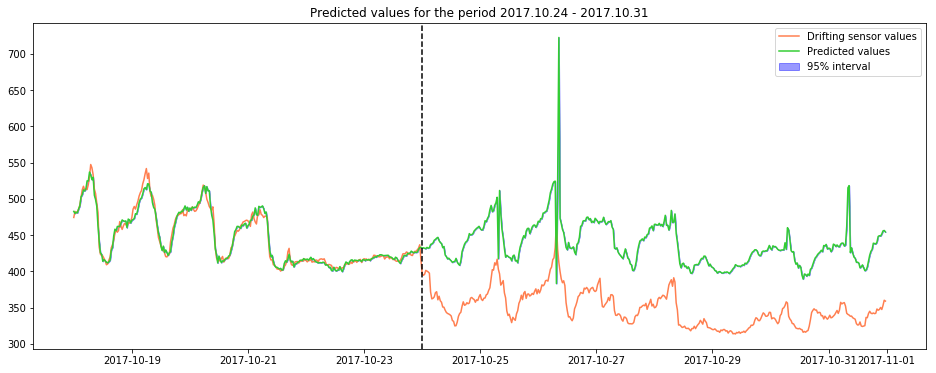

In [65]:
plot_pred_conc(df_ts_pred_f_fin, "Predicted values for the period 2017.10.24 - 2017.10.31")

Although spikes are still present, the drift disappears. The prediction overall is convincing.

g) **Bonus (5):** Remove the drift with an advanced machine learning model of your choice. Discuss the results. 

In [66]:
X = np.stack(valid_data_x["CO2"].values)
y = valid_data_y

In [67]:
# Create AdaBoostRegressor
regressor = AdaBoostRegressor(n_estimators=1000, loss='square', random_state=42, learning_rate=1.2)

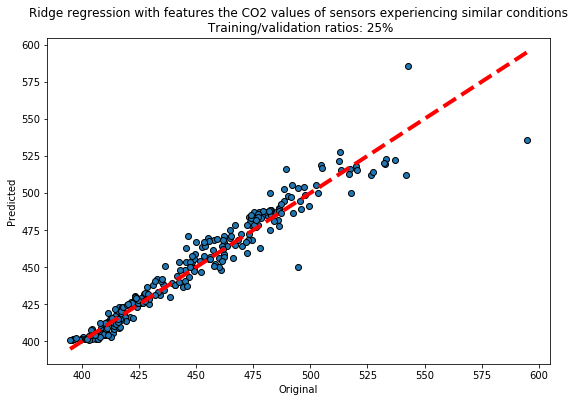

Average cross validation score: 0.880


In [68]:
y_test, y_pred = predict_co2(X, y, 0.25, regressor)
plot_pred(y_test, y_pred, "Ridge regression with features the CO2 values "\
                          "of sensors experiencing similar conditions\n "\
                          "Training/validation ratios: {:.0f}%".format(0.25*100))

print("Average cross validation score: {:.3f}".format(np.abs(cross_val_score(regressor, X, y, cv=5).mean())))

In [69]:
# Fit the model to the valid data
regressor.fit(X, y)

AdaBoostRegressor(base_estimator=None, learning_rate=1.2, loss='square',
         n_estimators=1000, random_state=42)

In [70]:
y_predicted = regressor.predict(X_pred)

In [71]:
df_ts_pred_g = df_training3.copy()
df_ts_pred_g_fin = df_ts_pred_g[df_ts_pred_g.LocationName == "ZSBN"].reset_index(level=1)
df_ts_pred_g_fin["CO2"] = y_predicted
df_ts_pred_g_fin["std"] = 0

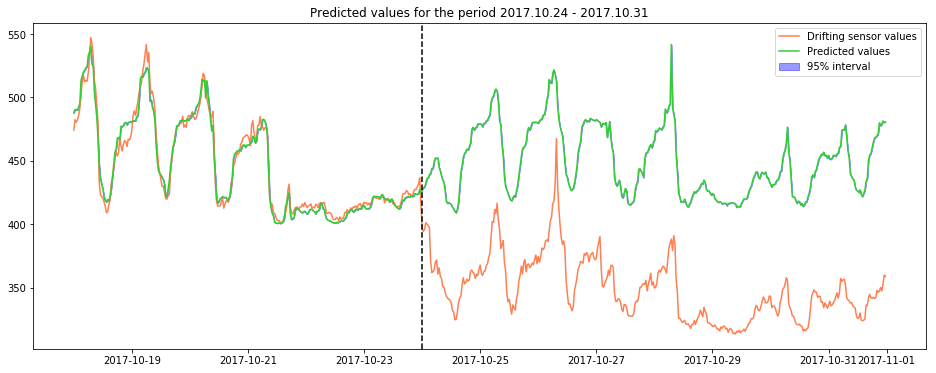

In [72]:
plot_pred_conc(df_ts_pred_g_fin, "Predicted values for the period 2017.10.24 - 2017.10.31")

By training an AdaBoostRegressor model, 88% accuracy is reached. Moreover, the graph shows that the drift and the spikes disappear.